#**Neural Networks**

In this notebook we'll create a 2-layer nueral network (i.e. a single hidden and output layer) and train it on the XOR data.

First, let's import NumPy, our layers and helper functions.

In [0]:
import os, glob
import tensorflow as tf
import numpy as np
import cv2 as cv
import warnings as warn
import skimage.measure as meas
from numpy import linalg as la, random as rand
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
X = rand.uniform(-1, 1, 50)
X = np.sort(X)
X

array([-0.90003429, -0.89672046, -0.86033069, -0.84684137, -0.80084678,
       -0.74430825, -0.72418926, -0.69851088, -0.68745917, -0.58323568,
       -0.54198028, -0.48910616, -0.45989081, -0.45129035, -0.44618573,
       -0.41169144, -0.40796625, -0.31905995, -0.21571084, -0.20903954,
       -0.16270405, -0.07236451,  0.00630423,  0.01905682,  0.04038624,
        0.09572403,  0.12101566,  0.12479024,  0.15773001,  0.16386132,
        0.18203006,  0.22235202,  0.22812499,  0.28492011,  0.29378029,
        0.3593506 ,  0.36383185,  0.39512507,  0.50805498,  0.52952438,
        0.59355294,  0.59742788,  0.69935019,  0.74849643,  0.7657048 ,
        0.84568607,  0.86527145,  0.89744363,  0.95536742,  0.97183697])

In [0]:
f = 1
y = np.sin(2*np.pi*f*X)
y

array([ 0.58761094,  0.60432987,  0.76918717,  0.82052223,  0.94939894,
        0.9993606 ,  0.98687865,  0.94812363,  0.92378133,  0.49946855,
        0.26072189, -0.06839461, -0.24935432, -0.30129622, -0.33171888,
       -0.52682347, -0.54657195, -0.90732613, -0.97688133, -0.96706475,
       -0.85330936, -0.43917448,  0.03960026,  0.11945163,  0.25103971,
        0.56584014,  0.68918508,  0.70617425,  0.83659994,  0.85707806,
        0.91018423,  0.98494904,  0.99056933,  0.97602615,  0.96240355,
        0.77310771,  0.75494465,  0.61228594, -0.0505893 , -0.18444501,
       -0.55454032, -0.57463446, -0.94978692, -0.99995538, -0.99513546,
       -0.82464994, -0.74898207, -0.60070342, -0.27677349, -0.17603148])

However, in order to fit our functions, we must first colapse it such that the output Y is the sum of the polynomials of the input value X multiplied to the coefficients W.

Therefore we setup a larger dataset using the following function

In [0]:
features = pd.DataFrame('0': [],'1':[], '2':[],'3': [],'4':[])
features

""


In [0]:
max_exp = 10
for x_element in X:
  k = 0
  data = []
  while k <= max_exp:
    data.append(x_element**k)
    k+=1
  datapoints = list(data)
  features.append(datapoints, ignore_index=True)

In [0]:
features

""


Let's set up training data. Recall, data needs to be in $(features \times \text{number_of_examples})$ shape. So, we need to transpose X and Y.

In [0]:
new_entry = {'X0': [],'X': [],'X2':[], 'X3':[],'X4': [],'X5':[], 'Y' : []}
features = pd.DataFrame(new_entry)

Lets try it on a this simple dataset for curve fitting

In [0]:
powers = 5
ffs = []
for i in X_train:
  exponent = 0
  feature_space = []
  while exponent <= powers:
    feature_space.append(i**exponent)
    exponent+=1
  ffs.append(feature_space)

In [0]:
fmat = features.as_matrix(columns = ('X0','X','X2','X3','X4','X5'))
fmat.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


(50, 6)

In [0]:
features['X0'] = ffs[0][0]
features['X'] = ffs[0][1]
features['X2'] = ffs[0][2]
features['X3'] = ffs[0][3]
features['X4'] = ffs[0][4]
features['X5'] = ffs[0][5]
features['Y'] = y
features.head()

,X0,X,X2,X3,X4,X5,Y
0,1.0,-0.900034,0.810062,-0.729083,0.656200,-0.590602,0.587611
1,1.0,-0.896720,0.804108,-0.721060,0.646589,-0.579810,0.604330
2,1.0,-0.860331,0.740169,-0.636790,0.547850,-0.471332,0.769187
3,1.0,-0.846841,0.717140,-0.607304,0.514290,-0.435522,0.820522
4,1.0,-0.800847,0.641356,-0.513628,0.411337,-0.329418,0.949399


In [0]:
def Sigmoid(Z):
    return 1/(1+np.exp(-Z))

def Relu(Z):
    return np.maximum(0,Z)

def dRelu2(dZ, Z):    
    dZ[Z <= 0] = 0    
    return dZ

def dRelu(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def dSigmoid(Z):
    s = 1/(1+np.exp(-Z))
    dZ = s * (1-s)
    return dZ

In [0]:
class dlnet:
    def __init__(self, x, y):
        self.debug = 0;
        self.X=x
        self.Y=y
        self.Yh=np.zeros((1,self.Y.shape[1])) 
        self.L=2
        self.dims = [6, 15, 1] 
        self.param = {}
        self.ch = {}
        self.grad = {}
        self.loss = []
        self.lr=0.003
        self.sam = self.Y.shape[1]
        self.threshold=0.5
        
    def nInit(self):    
        np.random.seed(1)
        self.param['W1'] = np.random.randn(self.dims[1], self.dims[0]) / np.sqrt(self.dims[0]) 
        self.param['b1'] = np.zeros((self.dims[1], 1))        
        self.param['W2'] = np.random.randn(self.dims[2], self.dims[1]) / np.sqrt(self.dims[1]) 
        self.param['b2'] = np.zeros((self.dims[2], 1))                
        return 

    def forward(self):    
        Z1 = self.param['W1'].dot(self.X) + self.param['b1'] 
        A1 = Relu(Z1)
        self.ch['Z1'],self.ch['A1']=Z1,A1
        
        Z2 = self.param['W2'].dot(A1) + self.param['b2']  
        A2 = Linear(Z2)
        self.ch['Z2'],self.ch['A2']=Z2,A2

        self.Yh=A2
        loss=self.nloss(A2)
        return self.Yh, loss

    def nloss(self,Yh):
        loss = (1./self.sam) * (-np.dot(self.Y,np.log(Yh).T) - np.dot(1-self.Y, np.log(1-Yh).T))    
        return loss

    def backward(self):
        dLoss_Yh = - (np.divide(self.Y, self.Yh ) - np.divide(1 - self.Y, 1 - self.Yh))    
        
        dLoss_Z2 = dLoss_Yh * dSigmoid(self.ch['Z2'])    
        dLoss_A1 = np.dot(self.param["W2"].T,dLoss_Z2)
        dLoss_W2 = 1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2,self.ch['A1'].T)
        dLoss_b2 = 1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2, np.ones([dLoss_Z2.shape[1],1])) 
                            
        dLoss_Z1 = dLoss_A1 * dRelu(self.ch['Z1'])        
        dLoss_A0 = np.dot(self.param["W1"].T,dLoss_Z1)
        dLoss_W1 = 1./self.X.shape[1] * np.dot(dLoss_Z1,self.X.T)
        dLoss_b1 = 1./self.X.shape[1] * np.dot(dLoss_Z1, np.ones([dLoss_Z1.shape[1],1]))  
        
        self.param["W1"] = self.param["W1"] - self.lr * dLoss_W1
        self.param["b1"] = self.param["b1"] - self.lr * dLoss_b1
        self.param["W2"] = self.param["W2"] - self.lr * dLoss_W2
        self.param["b2"] = self.param["b2"] - self.lr * dLoss_b2
        
        return


    def pred(self,x, y):  
        self.X=x
        self.Y=y
        comp = np.zeros((1,x.shape[1]))
        pred, loss= self.forward()    
    
        for i in range(0, pred.shape[1]):
            if pred[0,i] > self.threshold: comp[0,i] = 1
            else: comp[0,i] = 0
    
        print("Acc: " + str(np.sum((comp == y)/x.shape[1])))
        
        return comp
    
    def gd(self,X, Y, iter = 3000):
        np.random.seed(1)                         
    
        self.nInit()
    
        for i in range(0, iter):
            Yh, loss=self.forward()
            self.backward()
        
            if i % 500 == 0:
                print ("Cost after iteration %i: %f" %(i, loss))
                self.loss.append(loss)

        plt.plot(np.squeeze(self.loss))
        plt.ylabel('Loss')
        plt.xlabel('Iter')
        plt.title("Lr =" + str(self.lr))
        plt.show()
    
        return

In [0]:
features.shape

(50, 7)

In [0]:
x_tr = features.iloc[0:40, : 6].values.transpose()
y_tr = np.expand_dims(features.iloc[0:40, 6],1).T
#x_tr = np.expand_dims(x_tr, 1)


In [0]:
xval = features.iloc[41:50, : 6].values.transpose()
yval = np.expand_dims(features.iloc[41:50, 6],1).T

In [0]:
nn = dlnet(x_tr,y_tr)

In [0]:
yval.shape

(1, 9)

Cost after iteration 0: 0.784179
Cost after iteration 500: 0.630888
Cost after iteration 1000: 0.598518
Cost after iteration 1500: 0.576412
Cost after iteration 2000: 0.555036
Cost after iteration 2500: 0.534417
Cost after iteration 3000: 0.514120
Cost after iteration 3500: 0.493970
Cost after iteration 4000: 0.473722
Cost after iteration 4500: 0.453316
Cost after iteration 5000: 0.432748
Cost after iteration 5500: 0.412022
Cost after iteration 6000: 0.391256
Cost after iteration 6500: 0.370632
Cost after iteration 7000: 0.350327
Cost after iteration 7500: 0.330472
Cost after iteration 8000: 0.311009
Cost after iteration 8500: 0.291911
Cost after iteration 9000: 0.273163
Cost after iteration 9500: 0.255471
Cost after iteration 10000: 0.238164
Cost after iteration 10500: 0.221067
Cost after iteration 11000: 0.203991
Cost after iteration 11500: 0.186844
Cost after iteration 12000: 0.169565
Cost after iteration 12500: 0.153300
Cost after iteration 13000: 0.137182
Cost after iteration 1350

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


Cost after iteration 62000: nan
Cost after iteration 62500: nan
Cost after iteration 63000: nan
Cost after iteration 63500: nan
Cost after iteration 64000: nan
Cost after iteration 64500: nan
Cost after iteration 65000: nan
Cost after iteration 65500: nan
Cost after iteration 66000: nan
Cost after iteration 66500: nan


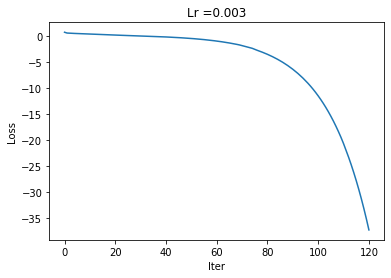

In [0]:
nn.gd(x, y, iter = 67000)

In [0]:
pred_train = nn.pred(x_tr, y_tr)
pred_test = nn.pred(xval, yval)

Acc: 0.0
Acc: 0.0
